# Cluster Users based on Topics

*This notebook computes topic models from documents and clusters users based on the topics.*

In [157]:
import json
import nlp
from gensim import corpora
from itertools import groupby
import numpy as np
from sklearn.cluster import KMeans
from sklearn import manifold

dataset = 'asm' # lss/asm
input_file = '../data/lss-17k.json'
output_file = '../data/lss-17k-topics.json'

if dataset == 'asm':
    input_file = '../data/lss_asm_dataset.txt'
    output_file = '../data/lss-asm-topics.json'

####  Load data

In [75]:
def load(filename):
    'A text file with each line as a JSON text.'
    p = parse_asm if dataset == 'asm' else parse_lss
    with open(filename) as file:
        sessions = [p(line) for line in file]
    return [s for s in sessions if s]

def parse_asm(text):
    'Return the list of actions from the given JSON text.'
    obj = json.loads(text)
    if 'actions' in obj and obj['actions'] and len(obj['actions']) <= 150: # limit max length to sync with the vis
        action = [a['name'][6:] for a in obj['actions']] #  [6:] to exclude the prefix 'Action'
        return { 'id': obj['session']['dcxID'], 'userId': obj['session']['user']['uid'], 'action': action }

def parse_lss(text):
    'Return the list of actions from the given JSON text.'
    obj = json.loads(text)
    if 'actionsQueue' in obj and obj['actionsQueue'] and obj['userId'] != 'none' and obj['officeId'] != 'none' and obj['orga'] != 'none':
        action = [a[6:] for a in obj['actionsQueue']] #  [6:] to exclude the prefix 'Action'
        return { 'id': obj['PFX'], 'action': action }

In [76]:
data = load(input_file)
docs = [d['action'] for d in data]
len(data), data[0]

(18957,
 {'action': ['SearchUsr',
   'SearchUsr',
   'DisplayOneUser',
   'UpdateUserDetails',
   'TabBar',
   'SearchUsr',
   'DisplayOneUser',
   'UpdateUserDetails',
   'TabBar',
   'TabBar'],
  'id': '2LK1J5ID313Q1BWKN##NAGHU91',
  'userId': 'Fisk, Richard'})

#### Compute topics with LDA

In [68]:
dictionary = corpora.Dictionary(docs)
corpus = [dictionary.doc2bow(doc) for doc in docs]
lda = nlp.build_lda_with_corpus(corpus, dictionary, num_topics=10)
lda.print_topics()

[(0,
  '0.551*"TabBar" + 0.171*"SearchUsr" + 0.135*"DisplayOneUser" + 0.044*"WarningDeleteUser" + 0.036*"DeleteUser" + 0.016*"FilterByApp" + 0.008*"Cancel" + 0.007*"DeleteDisplayedUser" + 0.006*"OneUserRoleDetails" + 0.006*"FilterByAppACL"'),
 (1,
  '0.505*"CloseTab" + 0.337*"TabBar" + 0.147*"CreateUser" + 0.005*"UpdateUserDetails" + 0.001*"DisplayInheritedTFARule" + 0.001*"ShowMatchingOffices" + 0.001*"SelectOrgaOrDescr" + 0.001*"NextToChooseDest" + 0.001*"SearchUsr" + 0.000*"AddOfficesToOrga"'),
 (2,
  '0.248*"CreateLoginArea" + 0.233*"AddNewLoginArea" + 0.136*"SearchUsr" + 0.085*"TpfRefreshTable" + 0.082*"ResetPwdUnlock" + 0.079*"DisplayOneUser" + 0.049*"DeleteLoginArea" + 0.026*"TpfMassImport" + 0.022*"FilterUsrLoginAreas" + 0.018*"SetAsDefault"'),
 (3,
  '0.152*"TabBar" + 0.117*"AssignRoleAclConfirmation1" + 0.100*"AssignRole1" + 0.089*"AssignRole2" + 0.064*"AssignAcl2" + 0.064*"AssignAcl1" + 0.054*"AssignACLStep3" + 0.048*"SearchRoleForAssignRoleAcl" + 0.046*"Cancel" + 0.026*"Fil

#### Cluster users
Each user is a vector of tasks 
 - $s = (p_1, p_2, ..., p_{k})$ with $p_i$ is the probability of task $i$
 - $u=\frac{1}{m}\sum_i^{m}{s_i}$ with $s_i$ is the vector representation of tasks for session $i$

In [79]:
for i, d in enumerate(data):
    d['index'] = i
data[0]

{'action': ['SearchUsr',
  'SearchUsr',
  'DisplayOneUser',
  'UpdateUserDetails',
  'TabBar',
  'SearchUsr',
  'DisplayOneUser',
  'UpdateUserDetails',
  'TabBar',
  'TabBar'],
 'id': '2LK1J5ID313Q1BWKN##NAGHU91',
 'index': 0,
 'userId': 'Fisk, Richard'}

In [90]:
data = sorted(data, key=lambda x: x['userId'])
users = groupby(data, key=lambda x: x['userId'])
users = [ { 'userId': k, 'sessions': [s['index'] for s in g] } for k, g in users ]
users[0]

{'sessions': [3361, 3469, 5827, 6678, 9095, 9836, 11151, 11656, 14016],
 'userId': "A'lars"}

Get session as vector of topics.

In [91]:
matrix = nlp.get_doc_topic_matrix(lda, corpus)

Get user as mean of session vector of topics

In [130]:
for u in users:
    u['topics'] = np.mean([matrix[s].reshape(1,-1) for s in u['sessions']], axis=0)
    
users[0]

In [146]:
km = KMeans(n_clusters=3, random_state=0)
labels = km.fit_predict(matrix)

In [154]:
ss = []
K = range(1, 30)
for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    km = km.fit(matrix)
    ss.append(km.inertia_)

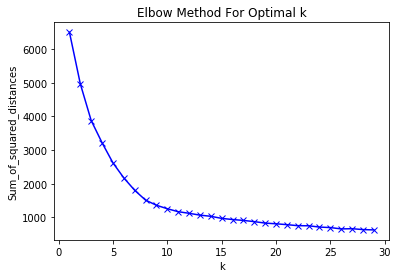

In [155]:
plt.plot(K, ss, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
def plot_projection(coords, topic_ids, palette):
    'Plot documents and color code their topics.'
    df = pd.DataFrame(data=np.c_[coords, topic_ids], columns= ['x', 'y', 'topic'])
    df.topic = df.topic.astype(int)
    sns.lmplot(data=df, x='x', y='y', hue='topic', palette=palette, fit_reg=False, size=6, aspect=1.6)

In [ ]:
plot_projection(manifold.MDS().fit_transform(doc_topic_matrix), topic_ids, 'Set3')

For n_clusters = 2 The average silhouette_score is : 0.2504407876572554
For n_clusters = 3 The average silhouette_score is : 0.326310528366219
For n_clusters = 4 The average silhouette_score is : 0.3674350282188349
For n_clusters = 5 The average silhouette_score is : 0.4063473483906661
For n_clusters = 6 The average silhouette_score is : 0.44278585478245247


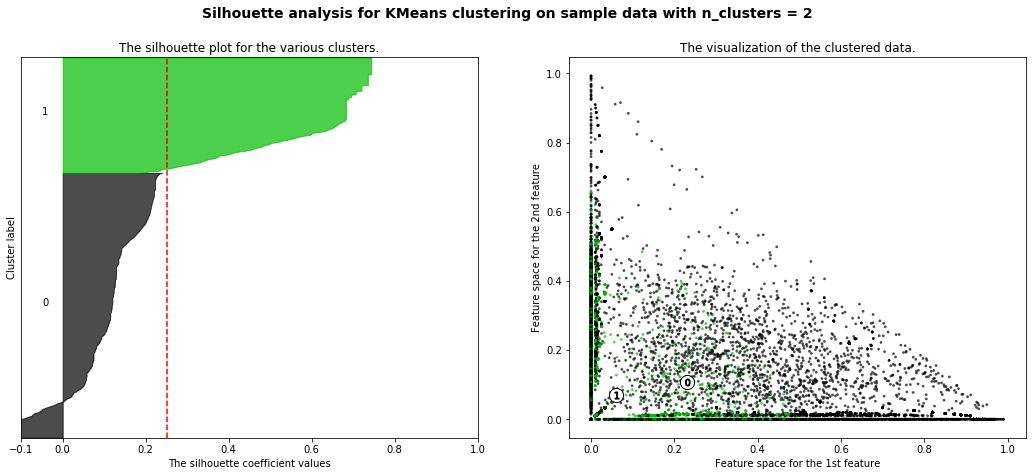

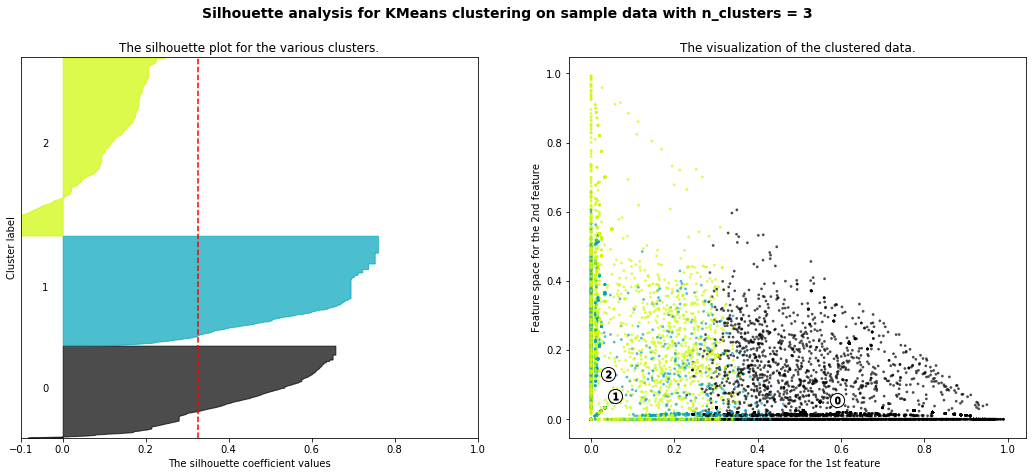

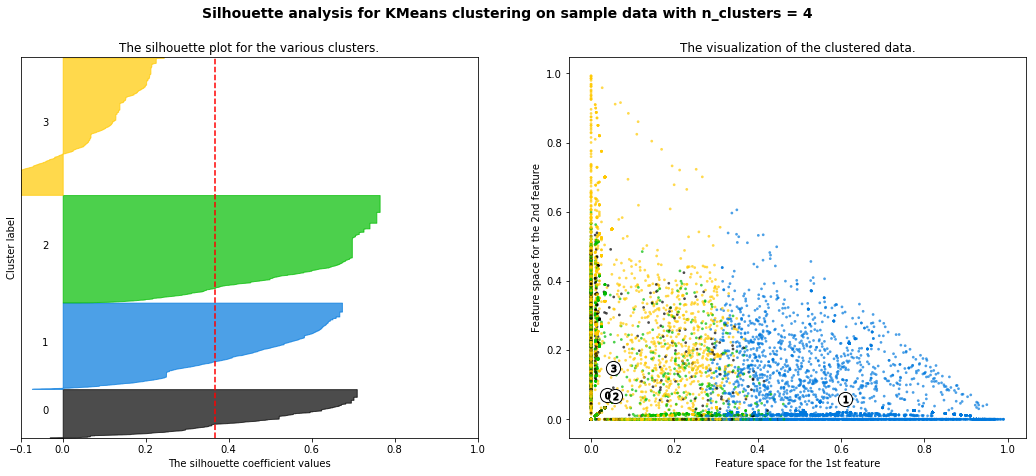

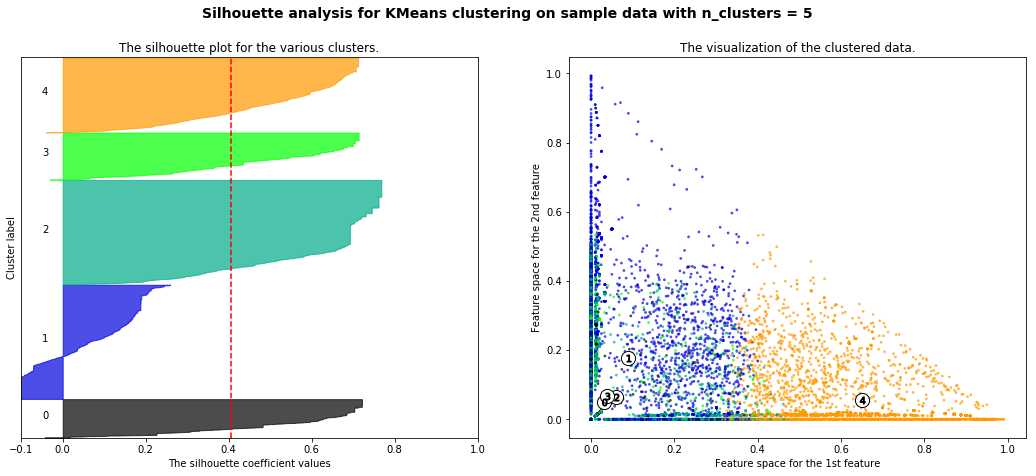

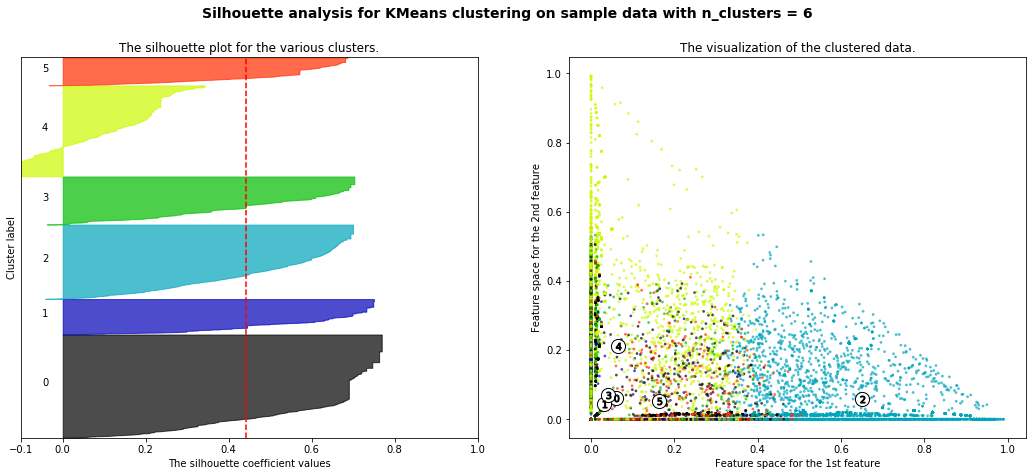

In [156]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(matrix) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(matrix)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(matrix, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(matrix, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(matrix[:, 0], matrix[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

#### Export data

In [39]:
with open(output_file, 'w') as f:
    json.dump({ 'topics': all_topics, 'sessions': output_data }, f)